# Modelleling

## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import *
from keras.callbacks import *
from keras.layers import *
from google.colab import files
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import math
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import datetime 

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_selected_final_24_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC  Price Prediction/data_selected_final_24_4.csv')

## Functions

### Sliding Windows & splitting data

In [5]:
def sliding_intervals(df):
  
  # selecting intervals with window side of 500
  window = 500
  window_interval = []
  train_windows = []
  test_windows = []

  # splitting each window into train and test data sets
  test_window = int(window*0.2)
  train_window = int(window*0.8)
  for i in range(0, len(df), test_window):
    if len(df.iloc[i:i+train_window,:]) >=400:
      window_interval.append(df.iloc[i:i+window,:].reset_index(drop=True)) 
      train_windows.append(df.iloc[i:i+train_window,:].reset_index(drop=True))
      test_windows.append(df.iloc[i+train_window:i+window,:].reset_index(drop=True))
  return window_interval,train_windows, test_windows

### Feature Scaling

In [6]:
# function to scale data with robust and min-max scalers
def scale_data(X_fit,X_tras):
  scale1 = RobustScaler()
  scale2 = MinMaxScaler()
  scale = make_pipeline(scale1,scale2)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to scale data with standard scaler
def scale_data1(X_fit,X_tras):
  scale1 = StandardScaler()
  scale = make_pipeline(scale1)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to decompose the data into components using PCA
def Principle_component_analysis(X_fit,X_tras,a):
  pca = PCA(n_components=a)  
  X_fit = pca.fit_transform(X_fit)
  X_tras = pca.transform(X_tras)
  return X_fit,X_tras


### Metrics

In [7]:
# Function to calculate Root Mean Square Error
# where y and y_pred are actual and predicted target variables
def RMSE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += math.pow((y[i]-y_pred[i]),2)
  MSE = sum/n
  RMSE = np.sqrt(MSE)
  return RMSE

In [8]:
# Function to calculate  Mean Absolute Error:
def MAE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAE = sum/n
  return MAE

In [9]:
# Function to calculate Mean Absolute Percentage Error:
def MAPE(y,y_pred):
  n =len(y)
  y_sum = np.sum(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAPE = (sum/y_sum)
  return MAPE

In [10]:
def metrics_final(data,y,y_pred):
  print('MAE_'+str(data)+':',MAE(y,y_pred))
  print('MAPE_'+str(data)+':',MAPE(y,y_pred))
  print('RMSE_'+str(data)+':',RMSE(y,y_pred))

### Outliers

In [11]:
# Function to remove outliers using isolation forest 
def outliers(df,a):
  outlier=IsolationForest(contamination=a)
  BTC_price = df['next_day_BTC_price'].values
  BTC_price=np.reshape(BTC_price,(-1,1))
  outlier.fit(BTC_price)
  outs=outlier.predict(BTC_price)
  df['outlier']=outs
  df_new=df.query('outlier != -1')
  df_new.drop(columns=['outlier'],inplace=True)
  return df_new

## LSTM 

In [12]:
data_selected_final = data_selected_final_24_4.copy()

In [13]:
window_interval,train_windows, test_windows = sliding_intervals(data_selected_final)

In [14]:
# Function to schedule learning rate for each epoch
def Learning_Rate_scheduler(epoch,lr):
    if (epoch+1) == 1:
        lr = 0.001
    if (epoch+1)%5==0:
        return lr*0.98
    else:
        return lr

In [15]:
# LSTM Algorithm
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, activation='relu'),input_shape=(1,12)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1))

adam=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)
model.compile(loss="log_cosh", optimizer=adam, metrics=['mae'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
lr_schedule=LearningRateScheduler(Learning_Rate_scheduler, verbose=True)
reduce_lr=ReduceLROnPlateau(monitor='mae', factor=0.98,patience=3,verbose=1,mode='min')

# Lists to store metric values
train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []
history = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data(x_train_windows,x_test_windows)

  x_train_windows_scaled=np.reshape(x_train_windows_scaled,
                                         (x_train_windows_scaled.shape[0],1,x_train_windows_scaled.shape[1]))
  y_train_windows=np.reshape(y_train_windows.values,(y_train_windows.shape[0],1,1))
  x_test_windows_scaled=np.reshape(x_test_windows_scaled,
                                        (x_test_windows_scaled.shape[0],1,x_test_windows_scaled.shape[1]))
  y_test_windows=np.reshape(y_test_windows.values,(y_test_windows.shape[0],1,1))

  history.append(model.fit(x_train_windows_scaled,y_train_windows, epochs=500, batch_size=32, 
                    validation_data=(x_test_windows_scaled,y_test_windows), callbacks=[earlyStopping,lr_schedule,reduce_lr]))

  y_train_pred_LSTM = model.predict(x_train_windows_scaled)
  y_test_pred_LSTM = model.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_LSTM))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_LSTM)))
  print(str(i+1)*75)
  print("train_metric_MAE:",train_metric_MAE)
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_LSTM)))
  print(str(i+1)*75)
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_LSTM)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_LSTM)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_LSTM)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_LSTM)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


Streaming output truncated to the last 5000 lines.

Epoch 25: LearningRateScheduler setting learning rate to 0.000800731354393065.
Epoch 25/500
13/13 [==============================] - 0s 14ms/step - loss: 493.8129 - mae: 494.5050 - val_loss: 356.4149 - val_mae: 357.1062 - lr: 8.0073e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0008007313590496778.
Epoch 26/500
11/13 [========================>.....] - ETA: 0s - loss: 523.7983 - mae: 524.4900
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0007847167318686842.
13/13 [==============================] - 0s 14ms/step - loss: 519.2634 - mae: 519.9553 - val_loss: 358.4772 - val_mae: 359.1704 - lr: 8.0073e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0007847167435102165.
Epoch 27/500
13/13 [==============================] - 0s 13ms/step - loss: 506.6771 - mae: 507.3700 - val_loss: 307.2685 - val_mae: 307.9616 - lr: 7.8472e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.00078471674351

In [16]:
LSTM_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [17]:
LSTM_metrics.iloc[:,2:].tail(5)

,mae_train,rmse_train,mape_train,mae_test,rmse_test,mape_test
19,668.800008,1152.874500,0.031065,1620.406879,2050.571413,0.040060
20,975.685822,1507.897798,0.032976,2272.151430,2689.104257,0.045244
21,1280.966121,1745.211422,0.032419,1251.994227,1738.752484,0.025794
22,1649.478264,2096.892011,0.035091,1204.806438,1580.338541,0.030765
23,1313.445650,1726.853297,0.029455,987.583650,1341.518903,0.033021


In [18]:
pd.DataFrame(LSTM_metrics.iloc[:,2:].mean())

,0
mae_train,377.413996
rmse_train,557.604413
mape_train,0.032751
mae_test,747.050833
rmse_test,998.033252
mape_test,0.057161


In [19]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

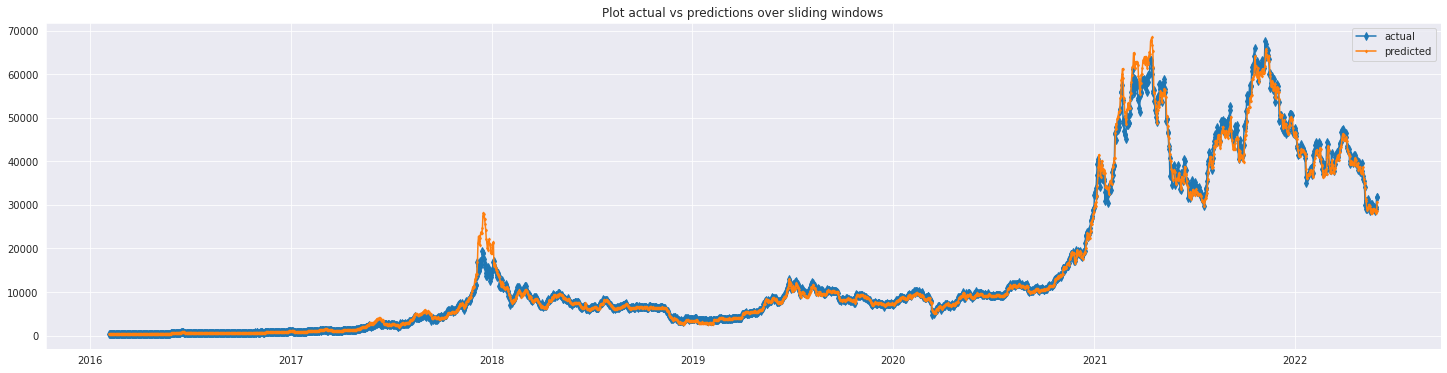

In [20]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()